<a href="https://colab.research.google.com/github/kyle-gao/GRSS_TrackMSD2021/blob/main/SuperResolutionWithABPN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Attention-based Back Projection Network
https://arxiv.org/pdf/1910.04476.pd

https://github.com/Holmes-Alan/ABPN

In [ ]:
import torch
import torch.nn as nn
from torch.nn import functional as F
import shutil
import gdal
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader

In [ ]:
extract_dir = "/content/validation"
file_dir = "/content/drive/MyDrive/validationdata.zip"
shutil.unpack_archive(file_dir, extract_dir, 'zip')  

In [ ]:
x=torch.tensor(gdal.Open("/content/validation/validation/1950_naip-2013.tif").ReadAsArray())[0,:,:]
x = F.pad(x,[10,10,10,10])

In [ ]:
def to_batches(img, kernel=5):
  """
  single band image eg.(3880,3880)
  output batches of image tiles eg (25,780,780)
  """
  return img.unfold(0,kernel,kernel).unfold(1,kernel,kernel).reshape(780,780,-1).permute((2,0,1))

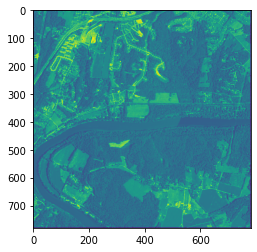

In [ ]:
x2=to_batches(x)
plt.imshow(x2[0,:,:])

In [ ]:
class ABPN_v3(nn.Module):
    def __init__(self, input_dim, dim):
        super(ABPN_v3, self).__init__()
        kernel_size = 10
        pad = 1
        stride = 8

        self.feat1 = ConvBlock(input_dim, 2 * dim, 3, 1, 1)
        self.SA0 = Space_attention(2 * dim, 2 * dim, 1, 1, 0, 1)
        self.feat2 = ConvBlock(2 * dim, dim, 3, 1, 1)
        # BP 1
        self.up1 = UpBlock(dim, dim, kernel_size, stride, pad)
        self.down1 = DownBlock(dim, dim, kernel_size, stride, pad)
        self.SA1 = Time_attention(dim, dim, 1, 1, 0, 1)
        # BP 2
        self.up2 = UpBlock(dim, dim, kernel_size, stride, pad)
        self.down2 = DownBlock(dim, dim, kernel_size, stride, pad)
        self.SA2 = Time_attention(dim, dim, 1, 1, 0, 1)
        # BP 3
        self.weight_up1 = ConvBlock(dim, dim, 1, 1, 0)
        self.up3 = UpBlock(dim, dim, kernel_size, stride, pad)
        self.weight_down1 = ConvBlock(dim, dim, 1, 1, 0)
        self.down3 = DownBlock(dim, dim, kernel_size, stride, pad)
        self.SA3 = Time_attention(dim, dim, 1, 1, 0, 1)
        # BP 4
        self.weight_up2 = ConvBlock(dim, dim, 1, 1, 0)
        self.up4 = UpBlock(dim, dim, kernel_size, stride, pad)
        self.weight_down2 = ConvBlock(dim, dim, 1, 1, 0)
        self.down4 = DownBlock(dim, dim, kernel_size, stride, pad)
        self.SA4 = Time_attention(dim, dim, 1, 1, 0, 1)
        # BP5
        self.weight_up3 = ConvBlock(dim, dim, 1, 1, 0)
        self.up5 = UpBlock(dim, dim, kernel_size, stride, pad)
        self.weight_down3 = ConvBlock(dim, dim, 1, 1, 0)
        self.down5 = DownBlock(dim, dim, kernel_size, stride, pad)
        self.SA5 = Time_attention(dim, dim, 1, 1, 0, 1)
        # BP6
        self.weight_up4 = ConvBlock(dim, dim, 1, 1, 0)
        self.up6 = UpBlock(dim, dim, kernel_size, stride, pad)
        # reconstruction
        self.SR_conv1 = ConvBlock(6 * dim, dim, 1, 1, 0)
        self.SR_conv2 = ConvBlock(dim, dim, 3, 1, 1)
        self.LR_conv1 = ConvBlock(5 * dim, dim, 1, 1, 0)
        self.LR_conv2 = UpBlock(dim, dim, kernel_size, stride, pad)
        self.SR_conv3 = nn.Conv2d(dim, input_dim, 3, 1, 1)

        for m in self.modules():
            classname = m.__class__.__name__
            if classname.find('Conv2d') != -1:
                torch.nn.init.kaiming_normal_(m.weight)
                if m.bias is not None:
                    m.bias.data.zero_()
            elif classname.find('ConvTranspose2d') != -1:
                torch.nn.init.kaiming_normal_(m.weight)
                if m.bias is not None:
                    m.bias.data.zero_()

    def forward(self, x):
        # feature extraction
        bic_x = F.interpolate(x, scale_factor=2, mode='bicubic')
        feat_x = self.feat1(bic_x)
        SA0 = self.SA0(feat_x)
        feat_x = self.feat2(SA0)
        # BP 1
        up1 = self.up1(feat_x)
        down1 = self.down1(up1)
        down1 = self.SA1(feat_x, down1)
        # BP 2
        up2 = self.up2(down1)
        down2 = self.down2(up2)
        down2 = self.SA2(down1, down2)
        # BP 3
        up3 = self.up3(down2) + self.weight_up1(up1)
        down3 = self.down3(up3)
        down3 = self.SA3(self.weight_down1(down1), down3)
        # BP 4
        up4 = self.up4(down3) + self.weight_up2(up2)
        down4 = self.down4(up4)
        down4 = self.SA4(self.weight_down2(down2), down4)
        # BP 5
        up5 = self.up5(down4) + self.weight_up3(up3)
        down5 = self.down5(up5)
        down5 = self.SA5(self.weight_down3(down3), down5)
        # BP 6
        up6 = self.up6(down5) + self.weight_up4(up4)
        # reconstruction
        HR_feat = torch.cat((up1, up2, up3, up4, up5, up6), 1)
        LR_feat = torch.cat((down1, down2, down3, down4, down5), 1)
        HR_feat = self.SR_conv1(HR_feat)
        HR_feat = self.SR_conv2(HR_feat)
        LR_feat = self.LR_conv1(LR_feat)
        LR_feat = self.LR_conv2(LR_feat)
        SR_res = self.SR_conv3(HR_feat + LR_feat)
        bic_x = F.interpolate(bic_x, scale_factor=8, mode='bicubic')
        
        SR = bic_x + SR_res

        
        return SR


class ABPN_v5(nn.Module):
    def __init__(self, input_dim, dim):
        super(ABPN_v5, self).__init__()
        kernel_size = 6
        pad = 1
        stride = 4

        self.feat1 = ConvBlock(input_dim, 2 * dim, 3, 1, 1)
        self.SA0 = Space_attention(2 * dim, 2 * dim, 1, 1, 0, 1)
        self.feat2 = ConvBlock(2 * dim, dim, 3, 1, 1)
        # BP 1
        self.up1 = UpBlock(dim, dim, kernel_size, stride, pad)
        self.down1 = DownBlock(dim, dim, kernel_size, stride, pad)
        self.SA1 = Time_attention(dim, dim, 1, 1, 0, 1)
        # BP 2
        self.up2 = UpBlock(dim, dim, kernel_size, stride, pad)
        self.down2 = DownBlock(dim, dim, kernel_size, stride, pad)
        self.SA2 = Time_attention(dim, dim, 1, 1, 0, 1)
        # BP 3
        self.weight_up1 = ConvBlock(dim, dim, 1, 1, 0)
        self.up3 = UpBlock(dim, dim, kernel_size, stride, pad)
        self.weight_down1 = ConvBlock(dim, dim, 1, 1, 0)
        self.down3 = DownBlock(dim, dim, kernel_size, stride, pad)
        self.SA3 = Time_attention(dim, dim, 1, 1, 0, 1)
        # BP 4
        self.weight_up2 = ConvBlock(dim, dim, 1, 1, 0)
        self.up4 = UpBlock(dim, dim, kernel_size, stride, pad)
        self.weight_down2 = ConvBlock(dim, dim, 1, 1, 0)
        self.down4 = DownBlock(dim, dim, kernel_size, stride, pad)
        self.SA4 = Time_attention(dim, dim, 1, 1, 0, 1)
        # BP5
        self.weight_up3 = ConvBlock(dim, dim, 1, 1, 0)
        self.up5 = UpBlock(dim, dim, kernel_size, stride, pad)
        self.weight_down3 = ConvBlock(dim, dim, 1, 1, 0)
        self.down5 = DownBlock(dim, dim, kernel_size, stride, pad)
        self.SA5 = Time_attention(dim, dim, 1, 1, 0, 1)
        # BP6
        self.weight_up4 = ConvBlock(dim, dim, 1, 1, 0)
        self.up6 = UpBlock(dim, dim, kernel_size, stride, pad)
        self.weight_down4 = ConvBlock(dim, dim, 1, 1, 0)
        self.down6 = DownBlock(dim, dim, kernel_size, stride, pad)
        self.SA6 = Time_attention(dim, dim, 1, 1, 0, 1)
        # BP7
        self.weight_up5 = ConvBlock(dim, dim, 1, 1, 0)
        self.up7 = UpBlock(dim, dim, kernel_size, stride, pad)
        self.weight_down5 = ConvBlock(dim, dim, 1, 1, 0)
        self.down7 = DownBlock(dim, dim, kernel_size, stride, pad)
        self.SA7 = Time_attention(dim, dim, 1, 1, 0, 1)
        # BP8
        self.weight_up6 = ConvBlock(dim, dim, 1, 1, 0)
        self.up8 = UpBlock(dim, dim, kernel_size, stride, pad)
        self.weight_down6 = ConvBlock(dim, dim, 1, 1, 0)
        self.down8 = DownBlock(dim, dim, kernel_size, stride, pad)
        self.SA8 = Time_attention(dim, dim, 1, 1, 0, 1)
        # BP9
        self.weight_up7 = ConvBlock(dim, dim, 1, 1, 0)
        self.up9 = UpBlock(dim, dim, kernel_size, stride, pad)
        self.weight_down7 = ConvBlock(dim, dim, 1, 1, 0)
        self.down9 = DownBlock(dim, dim, kernel_size, stride, pad)
        self.SA9 = Time_attention(dim, dim, 1, 1, 0, 1)
        # BP10
        self.weight_up8 = ConvBlock(dim, dim, 1, 1, 0)
        self.up10 = UpBlock(dim, dim, kernel_size, stride, pad)
        self.weight_down8 = ConvBlock(dim, dim, 1, 1, 0)
        self.down10 = DownBlock(dim, dim, kernel_size, stride, pad)
        self.SA10 = Time_attention(dim, dim, 1, 1, 0, 1)
        # reconstruction
        self.SR_conv1 = ConvBlock(10 * dim, dim, 1, 1, 0)
        self.SR_conv2 = ConvBlock(dim, dim, 3, 1, 1)
        self.LR_conv1 = ConvBlock(9 * dim, dim, 1, 1, 0)
        self.LR_conv2 = UpBlock(dim, dim, kernel_size, stride, pad)
        self.SR_conv3 = nn.Conv2d(dim, input_dim, 3, 1, 1)
        # BP final
        self.final_feat1 = ConvBlock(input_dim, 2 * dim, 3, 1, 1)
        self.final_SA0 = Space_attention(2 * dim, 2 * dim, 1, 1, 0, 1)
        self.final_feat2 = nn.Conv2d(2 * dim, input_dim, 3, 1, 1)

        for m in self.modules():
            classname = m.__class__.__name__
            if classname.find('Conv2d') != -1:
                torch.nn.init.kaiming_normal_(m.weight)
                if m.bias is not None:
                    m.bias.data.zero_()
            elif classname.find('ConvTranspose2d') != -1:
                torch.nn.init.kaiming_normal_(m.weight)
                if m.bias is not None:
                    m.bias.data.zero_()

    def forward(self, x):
        # feature extraction
        bic_x = F.interpolate(x, scale_factor=4, mode='bicubic')
        feat_x = self.feat1(x)
        SA0 = self.SA0(feat_x)
        feat_x = self.feat2(SA0)
        # BP 1
        up1 = self.up1(feat_x)
        down1 = self.down1(up1)
        down1 = self.SA1(feat_x, down1)
        # BP 2
        up2 = self.up2(down1)
        down2 = self.down2(up2)
        down2 = self.SA2(down1, down2)
        # BP 3
        up3 = self.up3(down2) + self.weight_up1(up1)
        down3 = self.down3(up3)
        down3 = self.SA3(self.weight_down1(down1), down3)
        # BP 4
        up4 = self.up4(down3) + self.weight_up2(up2)
        down4 = self.down4(up4)
        down4 = self.SA4(self.weight_down2(down2), down4)
        # BP 5
        up5 = self.up5(down4) + self.weight_up3(up3)
        down5 = self.down5(up5)
        down5 = self.SA5(self.weight_down3(down3), down5)
        # BP 6
        up6 = self.up6(down5) + self.weight_up4(up4)
        down6 = self.down6(up6)
        down6 = self.SA6(self.weight_down4(down4), down6)
        # BP 7
        up7 = self.up7(down6) + self.weight_up5(up5)
        down7 = self.down7(up7)
        down7 = self.SA7(self.weight_down5(down5), down7)
        # BP 8
        up8 = self.up8(down7) + self.weight_up6(up6)
        down8 = self.down8(up8)
        down8 = self.SA8(self.weight_down6(down6), down8)
        # BP 9
        up9 = self.up9(down8) + self.weight_up7(up7)
        down9 = self.down9(up9)
        down9 = self.SA9(self.weight_down7(down7), down9)
        # BP 10
        up10 = self.up10(down9) + self.weight_up8(up8)
        # reconstruction
        HR_feat = torch.cat((up1, up2, up3, up4, up5, up6, up7, up8, up9, up10), 1)
        LR_feat = torch.cat((down1, down2, down3, down4, down5, down6, down7, down8, down9), 1)
        HR_feat = self.SR_conv1(HR_feat)
        HR_feat = self.SR_conv2(HR_feat)
        LR_feat = self.LR_conv1(LR_feat)
        LR_feat = self.LR_conv2(LR_feat)
        SR_res = self.SR_conv3(HR_feat + LR_feat)

        SR = bic_x + SR_res

        LR_res = x - F.interpolate(SR, scale_factor=0.25, mode='bicubic')
        LR_res = self.final_feat1(LR_res)
        LR_SA = self.final_SA0(LR_res)
        LR_res = self.final_feat2(LR_SA)

        SR_res = F.interpolate(LR_res, scale_factor=4, mode='bicubic')


        SR = SR + SR_res

        return SR



############################################################################################
# Base models
############################################################################################

class ConvBlock(torch.nn.Module):
    def __init__(self, input_size, output_size, kernel_size, stride, padding, bias=True):
        super(ConvBlock, self).__init__()

        self.conv = torch.nn.Conv2d(input_size, output_size, kernel_size, stride, padding, bias=bias)

        self.act = torch.nn.PReLU()

    def forward(self, x):
        out = self.conv(x)

        return self.act(out)


class DeconvBlock(torch.nn.Module):
    def __init__(self, input_size, output_size, kernel_size, stride, padding, bias=True):
        super(DeconvBlock, self).__init__()

        self.deconv = torch.nn.ConvTranspose2d(input_size, output_size, kernel_size, stride, padding, bias=bias)

        self.act = torch.nn.PReLU()

    def forward(self, x):
        out = self.deconv(x)

        return self.act(out)


class UpBlock(torch.nn.Module):
    def __init__(self, input_size, output_size, kernel_size, stride, padding):
        super(UpBlock, self).__init__()

        self.conv1 = DeconvBlock(input_size, output_size, kernel_size, stride, padding, bias=True)
        self.conv2 = ConvBlock(output_size, output_size, kernel_size, stride, padding, bias=True)
        self.conv3 = DeconvBlock(output_size, output_size, kernel_size, stride, padding, bias=True)
        self.local_weight1 = ConvBlock(input_size, output_size, kernel_size=1, stride=1, padding=0, bias=True)
        self.local_weight2 = ConvBlock(output_size, output_size, kernel_size=1, stride=1, padding=0, bias=True)

    def forward(self, x):
        hr = self.conv1(x)
        lr = self.conv2(hr)
        residue = self.local_weight1(x) - lr
        h_residue = self.conv3(residue)
        hr_weight = self.local_weight2(hr)
        return hr_weight + h_residue


class DownBlock(torch.nn.Module):
    def __init__(self, input_size, output_size, kernel_size, stride, padding):
        super(DownBlock, self).__init__()

        self.conv1 = ConvBlock(input_size, output_size, kernel_size, stride, padding, bias=True)
        self.conv2 = DeconvBlock(output_size, output_size, kernel_size, stride, padding, bias=True)
        self.conv3 = ConvBlock(output_size, output_size, kernel_size, stride, padding, bias=True)
        self.local_weight1 = ConvBlock(input_size, output_size, kernel_size=1, stride=1, padding=0, bias=True)
        self.local_weight2 = ConvBlock(output_size, output_size, kernel_size=1, stride=1, padding=0, bias=True)

    def forward(self, x):
        lr = self.conv1(x)
        hr = self.conv2(lr)
        residue = self.local_weight1(x) - hr
        l_residue = self.conv3(residue)
        lr_weight = self.local_weight2(lr)
        return lr_weight + l_residue


class ResnetBlock(torch.nn.Module):
    def __init__(self, num_filter, kernel_size=3, stride=1, padding=1, bias=True):
        super(ResnetBlock, self).__init__()
        self.conv1 = torch.nn.Conv2d(num_filter, num_filter, kernel_size, stride, padding, bias=bias)
        self.conv2 = torch.nn.Conv2d(num_filter, num_filter, kernel_size, stride, padding, bias=bias)

        self.act1 = torch.nn.PReLU()
        self.act2 = torch.nn.PReLU()

    def forward(self, x):

        out = self.conv1(x)
        out = self.act1(out)
        out = self.conv2(out)
        out = out + x
        out = self.act2(out)

        return out


class Space_attention(torch.nn.Module):
    def __init__(self, input_size, output_size, kernel_size, stride, padding, scale):
        super(Space_attention, self).__init__()

        self.input_size = input_size
        self.output_size = output_size
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        self.scale = scale
        # downscale = scale + 4

        self.K = torch.nn.Conv2d(input_size, output_size, kernel_size, stride, padding, bias=True)
        self.Q = torch.nn.Conv2d(input_size, output_size, kernel_size, stride, padding, bias=True)
        self.V = torch.nn.Conv2d(input_size, output_size, kernel_size, stride, padding, bias=True)
        self.pool = nn.MaxPool2d(kernel_size=self.scale + 2, stride=self.scale, padding=1)
        #self.bn = nn.BatchNorm2d(output_size)
        if kernel_size == 1:
            self.local_weight = torch.nn.Conv2d(output_size, input_size, kernel_size, stride, padding,
                                                bias=True)
        else:
            self.local_weight = torch.nn.ConvTranspose2d(output_size, input_size, kernel_size, stride, padding,
                                                         bias=True)


    def forward(self, x):
        batch_size = x.size(0)
        K = self.K(x)
        Q = self.Q(x)
        # Q = F.interpolate(Q, scale_factor=1 / self.scale, mode='bicubic')
        if self.stride > 1:
            Q = self.pool(Q)
        else:
            Q = Q
        V = self.V(x)
        # V = F.interpolate(V, scale_factor=1 / self.scale, mode='bicubic')
        if self.stride > 1:
            V = self.pool(V)
        else:
            V = V
        V_reshape = V.view(batch_size, self.output_size, -1)
        V_reshape = V_reshape.permute(0, 2, 1)
        # if self.type == 'softmax':
        Q_reshape = Q.view(batch_size, self.output_size, -1)

        K_reshape = K.view(batch_size, self.output_size, -1)
        K_reshape = K_reshape.permute(0, 2, 1)

        KQ = torch.matmul(K_reshape, Q_reshape)
        attention = F.softmax(KQ, dim=-1)

        vector = torch.matmul(attention, V_reshape)
        vector_reshape = vector.permute(0, 2, 1).contiguous()
        O = vector_reshape.view(batch_size, self.output_size, x.size(2) // self.stride, x.size(3) // self.stride)
        W = self.local_weight(O)
        output = x + W
        #output = self.bn(output)
        return output

class Space_attention_v2(torch.nn.Module):
    def __init__(self, input_size, output_size, kernel_size, stride, padding, scale):
        super(Space_attention_v2, self).__init__()

        self.input_size = input_size
        self.output_size = output_size
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        self.scale = scale
        # downscale = scale + 4

        self.K = torch.nn.Conv2d(input_size, output_size, kernel_size, stride, padding, bias=True)
        self.Q = torch.nn.Conv2d(input_size, output_size, kernel_size, stride, padding, bias=True)
        self.V = torch.nn.Conv2d(input_size, output_size, kernel_size, stride, padding, bias=True)
        self.pool = nn.MaxPool2d(kernel_size=self.scale + 2, stride=self.scale, padding=1)
        #self.bn = nn.BatchNorm2d(output_size)
        if kernel_size == 1:
            self.local_weight = torch.nn.Conv2d(output_size, input_size, kernel_size, stride, padding, bias=True)
        else:
            self.local_weight = torch.nn.ConvTranspose2d(output_size, input_size, kernel_size, stride, padding, bias=True)


    def forward(self, x):
        batch_size = x.size(0)
        K = self.K(x)
        Q = self.Q(x)
        # Q = F.interpolate(Q, scale_factor=1 / self.scale, mode='bicubic')
        if self.stride > 1:
            Q = self.pool(Q)
        else:
            Q = Q
        V = self.V(x)
        # V = F.interpolate(V, scale_factor=1 / self.scale, mode='bicubic')
        if self.stride > 1:
            V = self.pool(V)
        else:
            V = V
        V_reshape = V.view(batch_size, self.output_size, -1)
        V_reshape = V_reshape.permute(0, 2, 1)
        # if self.type == 'softmax':
        Q_reshape = Q.view(batch_size, self.output_size, -1)

        K_reshape = K.view(batch_size, self.output_size, -1)
        K_reshape = K_reshape.permute(0, 2, 1)

        QV = torch.matmul(Q_reshape, V_reshape)
        attention = F.softmax(QV, dim=-1)

        vector = torch.matmul(K_reshape, attention)
        vector_reshape = vector.permute(0, 2, 1).contiguous()
        O = vector_reshape.view(batch_size, self.output_size, x.size(2) // self.stride, x.size(3) // self.stride)
        W = self.local_weight(O)
        output = x + W
        #output = self.bn(output)
        return output

class Time_attention(torch.nn.Module):
    def __init__(self, input_size, output_size, kernel_size, stride, padding, scale):
        super(Time_attention, self).__init__()

        self.input_size = input_size
        self.output_size = output_size
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        self.scale = scale
        # downscale = scale + 4

        self.K = torch.nn.Conv2d(input_size, output_size, kernel_size, stride, padding, bias=True)
        self.Q = torch.nn.Conv2d(input_size, output_size, kernel_size, stride, padding, bias=True)
        self.V = torch.nn.Conv2d(input_size, output_size, kernel_size, stride, padding, bias=True)
        self.pool = nn.MaxPool2d(kernel_size=self.scale + 2, stride=self.scale, padding=1)
        #self.bn = nn.BatchNorm2d(output_size)
        if kernel_size == 1:
            self.local_weight = torch.nn.Conv2d(output_size, input_size, kernel_size, stride, padding,
                                                bias=True)
        else:
            self.local_weight = torch.nn.ConvTranspose2d(output_size, input_size, kernel_size, stride, padding,
                                                         bias=True)


    def forward(self, x, y):
        batch_size = x.size(0)
        K = self.K(x)
        Q = self.Q(x)
        # Q = F.interpolate(Q, scale_factor=1 / self.scale, mode='bicubic')
        if self.stride > 1:
            Q = self.pool(Q)
        else:
            Q = Q
        V = self.V(y)
        # V = F.interpolate(V, scale_factor=1 / self.scale, mode='bicubic')
        if self.stride > 1:
            V = self.pool(V)
        else:
            V = V
        #attention = x
        V_reshape = V.view(batch_size, self.output_size, -1)
        V_reshape = V_reshape.permute(0, 2, 1)

        # if self.type == 'softmax':
        Q_reshape = Q.view(batch_size, self.output_size, -1)

        K_reshape = K.view(batch_size, self.output_size, -1)
        K_reshape = K_reshape.permute(0, 2, 1)

        KQ = torch.matmul(K_reshape, Q_reshape)
        attention = F.softmax(KQ, dim=-1)
        vector = torch.matmul(attention, V_reshape)
        vector_reshape = vector.permute(0, 2, 1).contiguous()
        O = vector_reshape.view(batch_size, self.output_size, x.size(2) // self.stride, x.size(3) // self.stride)
        W = self.local_weight(O)
        output = y + W
        #output = self.bn(output)
        return output

class Time_attention_v2(torch.nn.Module):
    def __init__(self, input_size, output_size, kernel_size, stride, padding, scale):
        super(Time_attention_v2, self).__init__()

        self.input_size = input_size
        self.output_size = output_size
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        self.scale = scale
        # downscale = scale + 4

        self.K = torch.nn.Conv2d(input_size, output_size, kernel_size, stride, padding, bias=True)
        self.Q = torch.nn.Conv2d(input_size, output_size, kernel_size, stride, padding, bias=True)
        self.V = torch.nn.Conv2d(input_size, output_size, kernel_size, stride, padding, bias=True)
        self.pool = nn.MaxPool2d(kernel_size=self.scale + 2, stride=self.scale, padding=1)
        #self.bn = nn.BatchNorm2d(output_size)
        if kernel_size == 1:
            self.local_weight = torch.nn.Conv2d(output_size, input_size, kernel_size, stride, padding, bias=True)
        else:
            self.local_weight = torch.nn.ConvTranspose2d(output_size, input_size, kernel_size, stride, padding, bias=True)


    def forward(self, x, y):
        batch_size = x.size(0)
        K = self.K(x)
        Q = self.Q(x)
        # Q = F.interpolate(Q, scale_factor=1 / self.scale, mode='bicubic')
        if self.stride > 1:
            Q = self.pool(Q)
        else:
            Q = Q
        V = self.V(y)
        # V = F.interpolate(V, scale_factor=1 / self.scale, mode='bicubic')
        if self.stride > 1:
            V = self.pool(V)
        else:
            V = V
        #attention = x
        V_reshape = V.view(batch_size, self.output_size, -1)
        V_reshape = V_reshape.permute(0, 2, 1)

        # if self.type == 'softmax':
        Q_reshape = Q.view(batch_size, self.output_size, -1)

        K_reshape = K.view(batch_size, self.output_size, -1)
        K_reshape = K_reshape.permute(0, 2, 1)

        QV = torch.matmul(Q_reshape, V_reshape)
        attention = F.softmax(QV, dim=-1)
        vector = torch.matmul(K_reshape, attention)
        vector_reshape = vector.permute(0, 2, 1).contiguous()
        O = vector_reshape.view(batch_size, self.output_size, x.size(2) // self.stride, x.size(3) // self.stride)
        W = self.local_weight(O)
        output = y + W
        #output = self.bn(output)
        return output

class Space_Time_Attention(torch.nn.Module):
    def __init__(self, input_size, output_size, kernel_size, stride, padding, scale):
        super(Space_Time_Attention, self).__init__()

        self.input_size = input_size
        self.output_size = output_size
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        self.scale = scale

        # First Space Attention
        self.SA_x1 = Space_attention(input_size, output_size, kernel_size, stride, padding, scale)
        self.SA_y1 = Space_attention(input_size, output_size, kernel_size, stride, padding, scale)
        self.resblock_x1 = ResnetBlock(output_size, kernel_size=3, stride=1, padding=1, bias=True)
        self.resblock_y1 = ResnetBlock(output_size, kernel_size=3, stride=1, padding=1, bias=True)
        # First Time Attention
        self.TA_y1 = Time_attention(input_size, output_size, kernel_size, stride, padding, scale)

    def forward(self, x, y):
        # First Space attention
        x1 = self.SA_x1(x)
        y1 = self.SA_y1(y)
        x1 = self.resblock_x1(x1)
        # First Time attention
        y1 = self.TA_y1(x1, y1)
        y1 = self.resblock_y1(y1)

        return x1, y1


class Space_Time_Attention_v2(torch.nn.Module):
    def __init__(self, input_size, output_size, kernel_size, stride, padding, scale):
        super(Space_Time_Attention_v2, self).__init__()

        self.input_size = input_size
        self.output_size = output_size
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        self.scale = scale

        # First Space Attention
        self.SA_x1 = Space_attention_v2(input_size, output_size, kernel_size, stride, padding, scale)
        self.SA_y1 = Space_attention_v2(input_size, output_size, kernel_size, stride, padding, scale)
        self.resblock_x1 = ResnetBlock(output_size, kernel_size=3, stride=1, padding=1, bias=True)
        self.resblock_y1 = ResnetBlock(output_size, kernel_size=3, stride=1, padding=1, bias=True)
        # First Time Attention
        self.TA_y1 = Time_attention_v2(input_size, output_size, kernel_size, stride, padding, scale)

    def forward(self, x, y):
        # First Space attention
        x1 = self.SA_x1(x)
        y1 = self.SA_y1(y)
        x1 = self.resblock_x1(x1)
        # First Time attention
        y1 = self.TA_y1(x1, y1)
        y1 = self.resblock_y1(y1)

        return x1, y1

In [ ]:
torch.cuda.current_device()
torch.cuda.empty_cache()
torch.backends.cudnn.benchmark = True
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = ABPN_v3(input_dim=1, dim=32)
model = model.to(device)
model = torch.nn.DataParallel(model)

In [ ]:
from torchsummary import summary

In [ ]:
summary(model,(1,64,64))

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3063: UserWarning: Default upsampling behavior when mode=bicubic is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


RuntimeError: ignored